In [89]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


from utils import make_spiral, plot_data, plot_decision_boundary, plot_training_progress, plot_decision_boundary_roundwise

## **Set Up the Dataset**

In [ ]:
# Generate and plot the dataset
X, y = make_spiral(n_samples=100)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
plot_data(X, y)

# **Q1:**
*Implement and train a neural network on the dataset generated above. You are free to use any network architecture you think is useful. Finally, plot the decision boundary generated by your model.*

The training of a neural network can be devided into the following steps:
1. Initialization of the parameters W[1], b[1], W[2], b[2], . . .
2. Computation of the forward pass
(i. e. compute the activations of the network for a batch of training examples)
3. Evaluate the loss function based on the true labels
4. Propagate the error gradients backwards through the network and update the
parameters (this step is referred to as backpropagation)
5. Update the weights using the gradient descent update rule

> -> Steps (2) to (5) are repeated until the network performs satisfactorily or until a fixed
number of iterations specified in advance has been performed

### **Setting Up PyTorch & Data-Set**

<div class="alert alert-block alert-success">
<b>Up to you:</b> Using the correct Resources for Trining could improve the Trainin Speed and Performance of the Model.
</div>

In [91]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


#### Dataset and DataLoader

In PyTorch Datasets and Dataloader can be used for better Performance:

**Dataset-Klasse:**
- Diese Klasse dient dazu, den Datensatz in einer Art Container zu verpacken, den PyTorch dann verarbeiten kann.
- Die Klasse SpiralDataset erbt von torch.utils.data.Dataset, einer abstrakten Klasse, die genau die zwei Methoden __len__() und __getitem__() implementiert.
- __init__() wird verwendet, um die Daten (Features X und Labels y) zu speichern, wobei sie in Torch-Tensoren umgewandelt werden, was notwendig ist, um sie in PyTorch weiter bearbeiten zu können.
- __len__() gibt die Anzahl der Datenpunkte im Datensatz zurück.
- __getitem__() gibt einen einzelnen Datenpunkt zurück, bestehend aus einem Feature-Vektor und einem Label, basierend auf einem gegebenen Index.

**DataLoader:**
- Der DataLoader ist verantwortlich für das Laden von Daten in Batches und das Shufflen der Daten, falls erwünscht.
- PyTorch's *DataLoader* übernimmt die Aufgabe, die Daten effizient zu laden und stapelweise zu verarbeiten, wodurch das Training beschleunigt wird.
- *DataLoader(dataset, batch_size=32, shuffle=True)* erstellt einen DataLoader, der die Daten aus dem dataset in Batches von 32 Beispielpunkten lädt und die Daten vor jedem Epoche-Training mischt.

In [ ]:
# Define Dataset and DataLoader
class SpiralDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SpiralDataset(X, y)
dataloader = DataLoader(dataset, batch_size=300, shuffle=True) # Bacht size of 1 -> Stochastic Gradient Descent (SGD)

### **Design the Model and intialize the Parameters**

The Parameters are inititalized normal-ditributet around 0

In [93]:
# Step 4: Define the Neural Network Architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden_layer_1 = nn.Linear(2, 10)
        self.hidden_layer_2 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 2)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

        # Initialize weights with normal distribution
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.relu(self.hidden_layer_1(x))
        x = self.relu(self.hidden_layer_2(x))
        x = self.softmax(self.output_layer(x))
        return x

**Alternative: Pipeline-Architektur**

Eine alternative Methode ist die Verwendung von nn.Sequential, um eine Pipeline-Architektur zu definieren. nn.Sequential erlaubt es, die Layer eines Modells in der Reihenfolge zu spezifizieren, in der die Daten durch diese fließen, ohne eine explizite forward()-Methode zu definieren:

In [94]:
# model = nn.Sequential(
# nn.Linear(2, 10),
# nn.ReLU(),
# nn.Linear(10, 10),
# nn.ReLU(),
# nn.Linear(10, 2)
# )

In [95]:
# Step 5: Instantiate the model, define the loss function and optimizer
model = NeuralNetwork()

### **Perform a singel forward Pass:**

(And Evaluate the Results)

In [96]:
# Perfrom one forward pass to check the model:
with torch.no_grad():
    sample_input = torch.tensor(X[:5], dtype=torch.float32)
    sample_output = model(sample_input)
    labels = torch.argmax(sample_output, dim=1)
    #criterion_output = criterion(sample_output, torch.tensor([0], dtype=torch.long))
    print(f"Sample input: {sample_input}, Sample output: {sample_output}, Resulting Label: {labels}" )#, Loss: {criterion_output.item()}")

Sample input: tensor([[-1.7769,  5.2217],
        [ 8.6473, -3.1784],
        [-2.2482, -7.1489],
        [-6.6416, -2.4775],
        [ 4.2191,  1.0704]]), Sample output: tensor([[0.5041, 0.4959],
        [0.4998, 0.5002],
        [0.5150, 0.4850],
        [0.5083, 0.4917],
        [0.4992, 0.5008]]), Resulting Label: tensor([0, 1, 0, 0, 1])


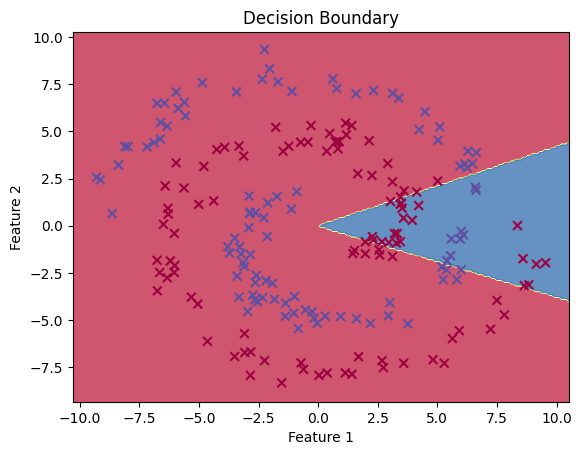

In [97]:
plot_decision_boundary(model, X, y)

### **Perform a singel Backpropagation**

#### Backpropagation Erklärung

##### Forward Pass

Die Berechnung der Aktivierung und des Outputs eines Neurons erfolgt wie folgt:

$$
z = w \cdot x + b
$$

mittels einer Aktivierungsfunktion, zum Beispiel ReLU:

$$
\text{ReLU}(x) = \max(0, x)
$$

##### Loss Funktion

Für die Verlustberechnung verwenden wir die Cross-Entropy:

$$
\text{Loss}(y, \hat{y}) = -\sum_{i} y_i \log(\hat{y}_i)
$$

##### Backward Pass

Berechnungen der Gradienten mit Bezug zur Verlustfunktion durch das Netzwerk:

$$
\frac{\partial L}{\partial w} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial w}
$$

##### Parameter-Update

Aktualisieren der Gewichte:

$$
w = w - \eta \frac{\partial L}{\partial w}
$$


In [98]:
# Show updated parameters
for name, param in model.named_parameters():
    print(f"\nOld parameters for {name}:\n", param.data)


Old parameters for hidden_layer_1.weight:
 tensor([[-0.2766,  0.0461],
        [-0.1638, -0.0987],
        [ 0.0501,  0.2608],
        [ 0.1217, -0.0177],
        [-0.0877,  0.1429],
        [-0.0064, -0.0845],
        [-0.0734,  0.0296],
        [-0.1255,  0.0239],
        [ 0.0020, -0.0576],
        [ 0.0715,  0.0613]])

Old parameters for hidden_layer_1.bias:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Old parameters for hidden_layer_2.weight:
 tensor([[-0.1158, -0.0654,  0.0408, -0.0299,  0.0812, -0.0214,  0.1519,  0.1929,
         -0.1069, -0.0201],
        [ 0.0066, -0.1256, -0.0354,  0.1267,  0.1329, -0.0943, -0.1934, -0.0146,
         -0.1177, -0.0709],
        [ 0.0906,  0.0900,  0.0202,  0.0846,  0.1116,  0.0045,  0.0580,  0.0369,
          0.1102, -0.0537],
        [ 0.2222, -0.0560,  0.1659, -0.0635, -0.0141,  0.0614, -0.0030, -0.0646,
          0.0110, -0.0088],
        [ 0.0647,  0.0044, -0.1399,  0.1003,  0.0946, -0.1961,  0.1118,  0.0191,
         -0.0486, -0.03

In [99]:
batch_X, batch_y = next(iter(dataloader))

# Perform a single forward pass
output_logits = model(batch_X)
print("Output logits:\n", output_logits)

# Calculate the loss
criterion = nn.CrossEntropyLoss()
loss = criterion(output_logits, batch_y)
print("\nLoss:\n", loss.item())

# Compute gradients (backward pass)
model.zero_grad()  # Clear previous gradients
loss.backward()    # Compute gradients

# Display gradients for each layer
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"\nGradients for {name}:\n", param.grad)

# Update Weights
# Normally done by optimizer, here for visualization only

learning_rate = 0.01
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad

# Show updated parameters
for name, param in model.named_parameters():
    print(f"\nUpdated parameters for {name}:\n", param.data)

Output logits:
 tensor([[0.4960, 0.5040],
        [0.5004, 0.4996],
        [0.5039, 0.4961],
        [0.5055, 0.4945],
        [0.4996, 0.5004],
        [0.5030, 0.4970],
        [0.5001, 0.4999],
        [0.5039, 0.4961],
        [0.5000, 0.5000],
        [0.5057, 0.4943],
        [0.5006, 0.4994],
        [0.5021, 0.4979],
        [0.5018, 0.4982],
        [0.5019, 0.4981],
        [0.5022, 0.4978],
        [0.4961, 0.5039],
        [0.5165, 0.4835],
        [0.5116, 0.4884],
        [0.5067, 0.4933],
        [0.5107, 0.4893],
        [0.5011, 0.4989],
        [0.5001, 0.4999],
        [0.4994, 0.5006],
        [0.5099, 0.4901],
        [0.4993, 0.5007],
        [0.5164, 0.4836],
        [0.5012, 0.4988],
        [0.5009, 0.4991],
        [0.5008, 0.4992],
        [0.4996, 0.5004],
        [0.5015, 0.4985],
        [0.5092, 0.4908],
        [0.5061, 0.4939],
        [0.4997, 0.5003],
        [0.5031, 0.4969],
        [0.5135, 0.4865],
        [0.5048, 0.4952],
        [0.4985, 0.501

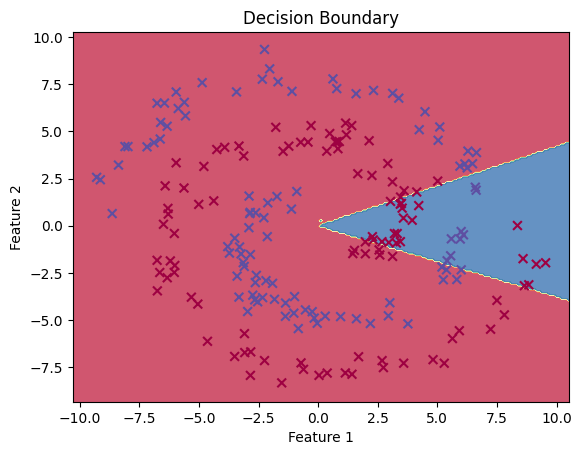

In [100]:
plot_decision_boundary(model, X, y)

### **Ittearate the Training**

In [101]:
# Funktion to perform the training of the model
def train_model(model, learning_rate=0.01, optimizer_fn=optim.Adam, loss_fn=nn.CrossEntropyLoss, num_epochs=100, plot_interval=10):
    criterion = loss_fn()
    optimizer = optimizer_fn(model.parameters(), lr=learning_rate)

    train_loss = []
    train_acc = []

    # Set up for plotting
    num_plots = num_epochs // plot_interval
    fig, axes = plt.subplots(nrows=num_plots//2, ncols=2, figsize=(12, 6 * (num_plots//2)))

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0

        for batch_X, batch_y in dataloader:
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                predictions = torch.argmax(y_pred, dim=1)
                correct += (predictions == batch_y).sum().item()

        train_loss.append(epoch_loss / len(dataloader))
        accuracy = correct / len(dataset)
        train_acc.append(accuracy * 100)

        # Plot interval
        if (epoch + 1) % plot_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss[-1]:.4f}, Accuracy: {train_acc[-1]:.2f}%")
            ax_index = (epoch // plot_interval) // 2, (epoch // plot_interval) % 2
            plot_decision_boundary_roundwise(model, X_tensor, y_tensor, axes[ax_index])

    # Plot final metrics with dual axes
    fig, ax1 = plt.subplots(figsize=(8, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color=color)
    ax1.plot(train_loss, color=color, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Train Accuracy (%)', color=color)
    ax2.plot(train_acc, color=color, label='Train Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and legends
    fig.suptitle('Training Loss and Accuracy')
    fig.tight_layout()  # For a cleaner layout
    plt.show()

    return model

Epoch [100/1000], Loss: 0.6166, Accuracy: 67.50%
Epoch [200/1000], Loss: 0.5239, Accuracy: 86.00%
Epoch [300/1000], Loss: 0.4103, Accuracy: 96.50%
Epoch [400/1000], Loss: 0.3585, Accuracy: 98.50%
Epoch [500/1000], Loss: 0.3392, Accuracy: 99.00%
Epoch [600/1000], Loss: 0.3282, Accuracy: 100.00%
Epoch [700/1000], Loss: 0.3222, Accuracy: 100.00%
Epoch [800/1000], Loss: 0.3194, Accuracy: 100.00%
Epoch [900/1000], Loss: 0.3174, Accuracy: 100.00%
Epoch [1000/1000], Loss: 0.3176, Accuracy: 100.00%


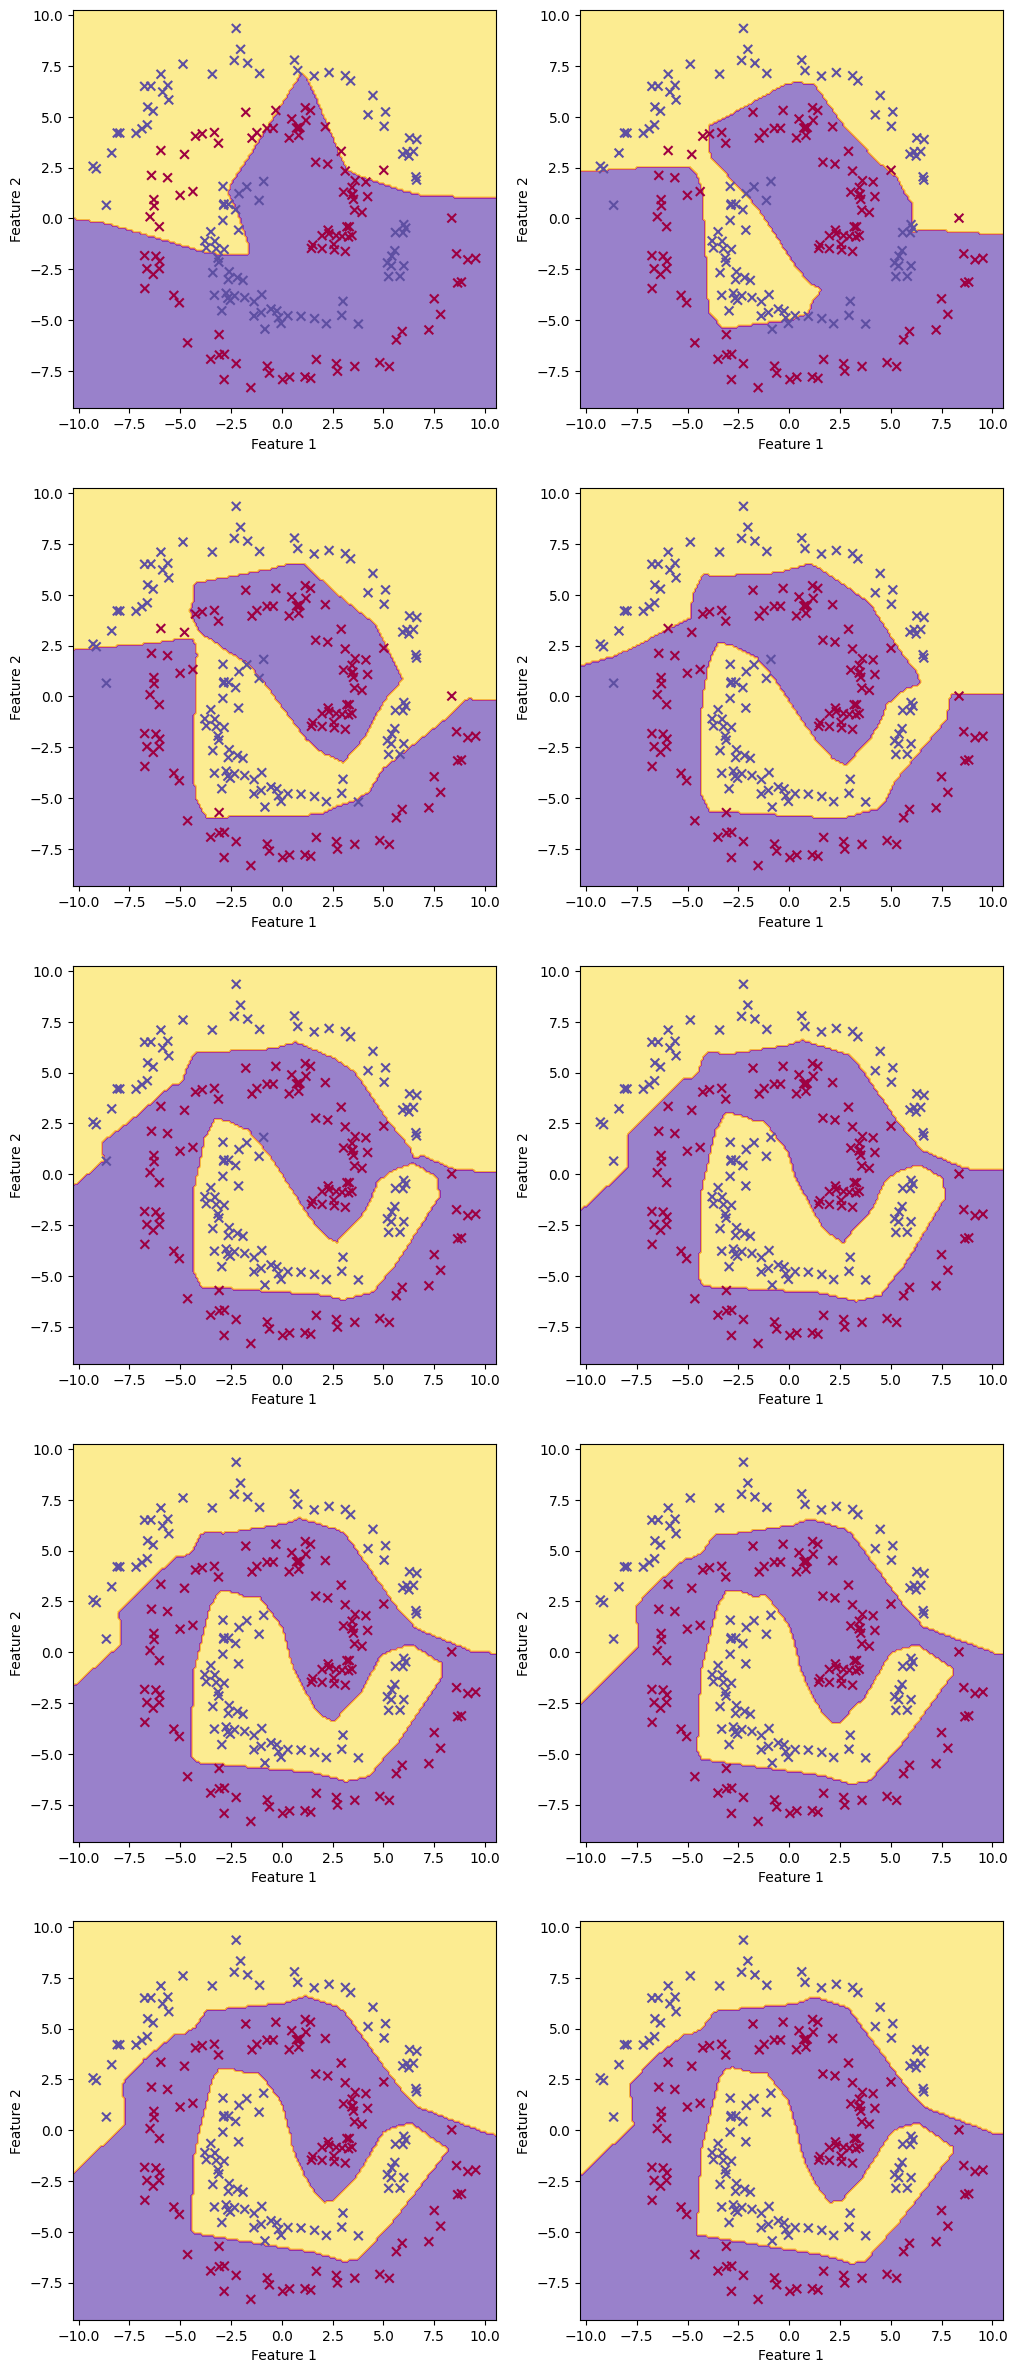

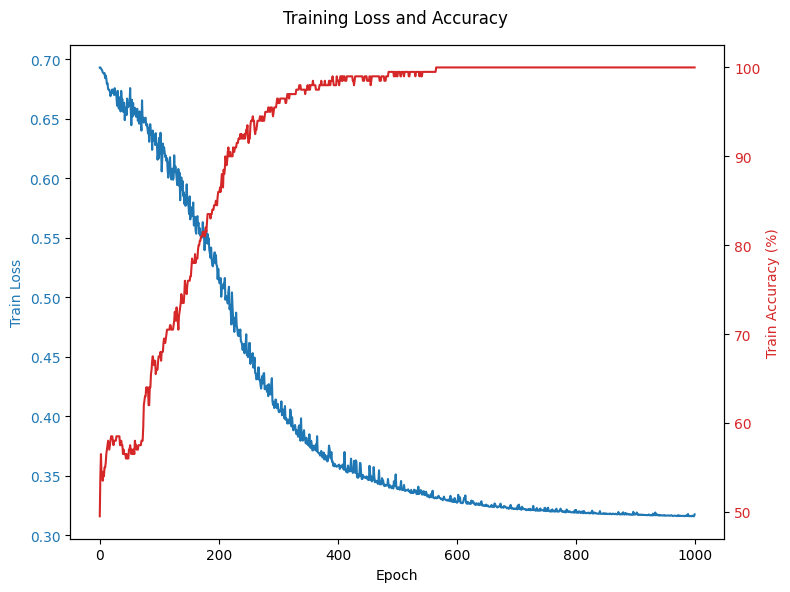

In [102]:
# Example for training the model with parameterized inputs
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # Bacht size of 1 -> Stochastic Gradient Descent (SGD)

model = train_model(model, learning_rate=0.001, optimizer_fn=optim.Adam, loss_fn=nn.CrossEntropyLoss, num_epochs=1000, plot_interval=100)

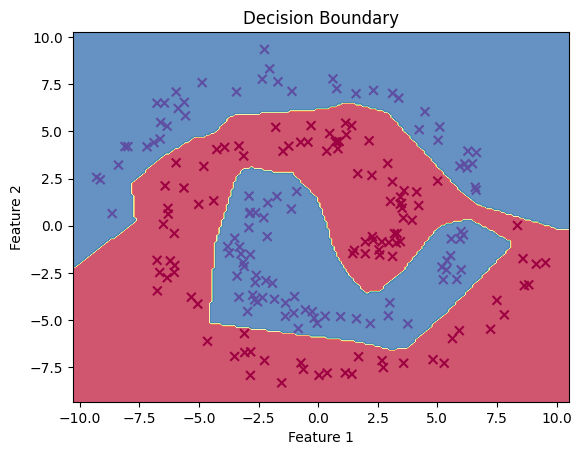

In [103]:
plot_decision_boundary(model, X, y)

# **TO DO**

--> erklären was wo wie berechnet wird

--> Aufzeigen eines Back-Propagation-Schrittes (einzelnene Berechnung darstellen) !!!!

--> Darstellen der Netz Architektur

--> Optimieren der Parameter